## Import Tools 

In [1]:
#Initial load
from RedDownloader import RedDownloader
import praw
import requests
import re
import os
import urllib.request
from PIL import Image
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics
import sys
import sklearn
from torchvision import datasets, transforms, utils
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV, cross_val_score, train_test_split
from scipy.stats import uniform
import random



### Set up Reddit credentials

In [2]:
reddit = praw.Reddit(
    client_id = "qK4Xv6veQzln_8kyWjqbSw",
    client_secret = "bvzcM1BI3Lv3vWAj4UmWU2GNjs1VIw",
    username = "AllHailAI",
    password = "ChrisSebChris",
    user_agent = "Test"
)

subreddit = reddit.subreddit('EarthPorn')
top = subreddit.top()




In [6]:
## Iterate through top pictures in subreddit. Can't download pictures from deleted accounts. Those are skipped
n_pictures = 200

submission_ids = []
upvote_ratio = []
upvote = []
channels = []

for submission in subreddit.top(limit = n_pictures):
    if submission.url.endswith('.jpg') or submission.url.endswith('.png'):

        try:
            urllib.request.urlretrieve(submission.url, "./Data/{filename}".format(filename = f"{submission.id}.{submission.url.split('.')[-1]}"))
            img = Image.open("./Data/{filename}.jpg".format(filename = submission.id))
            img = img.resize((224,224))

            img.save("./Data/{filename}.jpg".format(filename = submission.id))

            submission_ids.append(submission.id)
            upvote_ratio.append(submission.upvote_ratio)
            upvote.append(submission.score)
            channels.append(len(img.getbands()))

        except:
            pass

In [7]:
df = pd.DataFrame({'submission_id':submission_ids, "upvote_ratio":upvote_ratio, "upvote": upvote, "channels":channels})

print(df.head())

  submission_id  upvote_ratio  upvote  channels
0        7t0swm          0.93  104581         3
1        6t89rv          0.95   90654         3
2        8e4djh          0.94   88878         3
3        cshcdu          0.96   85088         3
4        6vkdh8          0.78   84359         3


In [3]:
random.seed(420)

# Normalize to mean and std of ImageNet
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),  
    ]
)


### Define CNN for classification

In [4]:

#Define CNN
learning_rate = 1e-4
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()

    
    #Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding = 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding = 1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding = 1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, padding=1)

    #Define pooling layers
        self.max_pool = nn.MaxPool2d(kernel_size=5, stride = 2)


    #Define fully connected layers
        self.fc1 = nn.Linear(128*28*28,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

    #Dropout some neurons to prevent overfitting.
        self.dropout = nn.Dropout(0.5)

    #Define activation functions
        self.relu = nn.ReLU()
        self.identity = nn.Identity()


#Apply convolutional layers with pooling in between
    def forward(self, x):
        x = self.max_pool(nn.functional.relu(self.conv1(x)))
        x = self.max_pool(nn.functional.relu(self.conv2(x)))
        x = self.max_pool(nn.functional.relu(self.conv3(x)))
        x = self.max_pool(nn.functional.relu(self.conv4(x)))
        x = self.max_pool(nn.functional.relu(self.conv5(x)))
        
        

#Flatten output
        x = x.view(-1, 128*28*28)

        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu((self.fc4(x)))
        x = self.identity(self.fc5(x))
        

        return x

model = Model()
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (identity): Identity()
)


### Load data 

In [5]:
data_path = "C:/Users/sebas/OneDrive/Dokumenter/skole/4 Semester/Fagprojekt/Data/RedditDataWithLinks.csv"
posts_tidy_df = pd.read_csv(data_path)
pd.set_option('display.max_columns', None)
posts_tidy_df

,Subreddit,SubredditID,PostTitle,PostID,TimeString,PostTime,Username,ViewCount,Upvotes,Ups,Downs,UpvoteRatio,CommentNumber,Edited,ImageDomain,ImageURL,Permalink,IsTextPost,PostText,SelfTextHTML,UserCreatedTime,AuthorName,Distinguished,LinkFlairClass,LinkFlairText,AuthorBirthdate,IsVideo,IsMeta,IsOriginal,IsRedditMediaDomain,IsCrosspostable,CrosspostsNumber,CrosspostParent,CrosspostParentList,SubRedditSubscribers,OnlyMedia,EmbeddedMedia,SecureEmbeddedMedia,Media,SecureMedia,Thumbnail,Stickied,Archived,IsHideScore,Pinned,PostHint,Preview,CommentsLocked,NSFW,NewURL,ScaledUpvoteRatio,AppliedScale
0,EarthPorn,t5_2sbq3,Howto: Set /r/EarthPorn to be your desktop wal...,gtdeu,2011-04-19 05:12:07,1303189927,pohatu,NaN,61,62.0,1.0,62.000000,30,True,self.EarthPorn,http://www.reddit.com/r/EarthPorn/comments/gtd...,/r/EarthPorn/comments/gtdeu/howto_set_rearthpo...,True,You can set Windows 7 to rotate desktop wallpa...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,default,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,1.000000,62.000000
1,EarthPorn,t5_2sbq3,Mosi-oa-Tunya (The Smoke that Thunders) - Vict...,q2ys4,2012-02-23 20:17:23,1330028243,jason-samfield,NaN,57,58.0,1.0,58.000000,3,False,flickr.com,http://www.flickr.com/photos/bletti/6841085143...,/r/EarthPorn/comments/q2ys4/mosioatunya_the_sm...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://b.thumbs.redditmedia.com/GOeIxLG0is3t58...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,//live.staticflickr.com/7145/6841085143_2bd0c9...,0.936508,54.317460
2,EarthPorn,t5_2sbq3,"Preikestolen, Norway. Panorama shoot",gi491,2011-04-04 05:44:30,1301895870,woooom,NaN,56,57.0,1.0,57.000000,5,False,virtualnorge.com,http://www.virtualnorge.com/preikestolen/preik...,/r/EarthPorn/comments/gi491/preikestolen_norwa...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://thumbs.reddit.com/t3_gi491.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,0.920635,52.476190
3,EarthPorn,t5_2sbq3,A view from Goverla moutain by Pavel Smolov. K...,urazd,2012-06-08 08:21:22,1339143682,kondrat1983,NaN,56,57.0,1.0,57.000000,2,False,farm5.staticflickr.com,http://farm5.staticflickr.com/4078/4910612774_...,/r/EarthPorn/comments/urazd/a_view_from_goverl...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://a.thumbs.redditmedia.com/FUEL3DwSjdlM1v...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,0.920635,52.476190
4,EarthPorn,t5_2sbq3,Foggy Trees [2560x1600],laah9,2011-10-13 01:40:49,1318470049,slyweazal,NaN,51,52.0,1.0,52.000000,6,False,i.imgur.com,http://i.imgur.com/seGXv.jpg,/r/EarthPorn/comments/laah9/foggy_trees_2560x1...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,http://thumbs.reddit.com/t3_laah9.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,http://i.imgur.com/seGXv.jpg,0.841270,43.746032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21653,EarthPorn,t5_2sbq3,The Midriff Islands of the Sea of Cortez,i3dv8,2011-06-19 04:33:14,1308457994,[deleted],NaN,0,1.0,6.0,0.166667,1,False,self.EarthPorn,http://www.reddit.com/r/EarthPorn/comments/i3d...,/r/EarthPorn/comments/i3dv8/the_midriff_island...,True,NaN,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{},NaN,NaN,NaN,default,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,0.018519,0.003086
21654,EarthPorn,t5_2sbq3,"Because they're scraping by on $393,000/year, ...",hy1de,2011-06-12 22:27:50,1307917670,nobodyspecial,NaN,0,1.0,7.0,0.142857,1,False,nytimes.com,http://www.nytimes.com/2011/06/12/us/12bcshort...,/r/EarthPorn/comments/hy1de/because_theyre_scr...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [6]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import os

def ImageWithScore(img_path, csv):
    data_path = pd.read_csv(csv)
    transformed_images = []
    scores = []
    corrupted = []
    counter = 0

    for index, row in data_path.iterrows():
        if counter % 1000 == 0:
            print('Current progress is at: {count}'.format(count=counter))

        submission_id = row['PostID'] + ".jpg"
        score = np.log10(row['AppliedScale'])
        image_path = os.path.join(img_path, submission_id)
        image_path = os.path.join(image_path).replace("\\", "/")
        if os.path.exists(image_path):
            try:
                with Image.open(image_path) as image:
                    # Normalize to mean and std of ImageNet
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ])

                    transformed_image = transform(image)
                    transformed_images.append(transformed_image)
                    scores.append(score)
                    counter += 1
            except Exception as e:
                print(f'Image failed: {submission_id}: {e}')
                corrupted.append(submission_id)
                counter += 1
        else:
            print(f'Image not found: {image_path}')
            counter += 1

    return transformed_images, scores

image_path = "C:/Users/sebas/OneDrive/Dokumenter/skole/4 Semester/Fagprojekt/Images/"
data_path = "C:/Users/sebas/OneDrive/Dokumenter/skole/4 Semester/Fagprojekt/Data/RedditDataWithLinks.csv"

transformed_images, scores = ImageWithScore(image_path, data_path)


Current progress is at: 0
Image not found: C:/Users/sebas/OneDrive/Dokumenter/skole/4 Semester/Fagprojekt/Images/gtdeu.jpg
Image not found: C:/Users/sebas/OneDrive/Dokumenter/skole/4 Semester/Fagprojekt/Images/gi491.jpg
Image not found: C:/Users/sebas/OneDrive/Dokumenter/skole/4 Semester/Fagprojekt/Images/urazd.jpg
Image not found: C:/Users/sebas/OneDrive/Dokumenter/skole/4 Semester/Fagprojekt/Images/si28w.jpg
Image not found: C:/Users/sebas/OneDrive/Dokumenter/skole/4 Semester/Fagprojekt/Images/vctcf.jpg
Image not found: C:/Users/sebas/OneDrive/Dokumenter/skole/4 Semester/Fagprojekt/Images/t8v9v.jpg
Image not found: C:/Users/sebas/OneDrive/Dokumenter/skole/4 Semester/Fagprojekt/Images/t1rna.jpg
Image not found: C:/Users/sebas/OneDrive/Dokumenter/skole/4 Semester/Fagprojekt/Images/sgcgk.jpg
Image not found: C:/Users/sebas/OneDrive/Dokumenter/skole/4 Semester/Fagprojekt/Images/tllxd.jpg
Image not found: C:/Users/sebas/OneDrive/Dokumenter/skole/4 Semester/Fagprojekt/Images/tux4b.jpg
Imag

In [7]:
print(transformed_images[:1])

[tensor([[[-0.1999, -0.0629, -0.0801,  ...,  0.5022,  0.1939,  0.0398],
         [ 0.1254,  0.2624,  0.1939,  ...,  0.0056, -0.0629, -0.1314],
         [ 0.3823,  0.5193,  0.4337,  ...,  0.1083,  0.0056, -0.3027],
         ...,
         [-1.2788, -1.1589, -1.0562,  ..., -1.9809, -1.9638, -1.8268],
         [-1.3302, -1.2103, -1.0904,  ..., -1.9638, -2.0152, -1.9124],
         [-1.3987, -1.2274, -1.0390,  ..., -1.9467, -2.0323, -1.9638]],

        [[ 0.1702,  0.3102,  0.2752,  ...,  0.4853,  0.1702,  0.0126],
         [ 0.4503,  0.5903,  0.5203,  ...,  0.0126, -0.0924, -0.1275],
         [ 0.6078,  0.7479,  0.6604,  ...,  0.1527, -0.0049, -0.2675],
         ...,
         [-1.3529, -1.1779, -1.0728,  ..., -1.9307, -1.9132, -1.7731],
         [-1.3529, -1.1954, -1.0728,  ..., -1.9132, -1.9657, -1.8606],
         [-1.4055, -1.2129, -1.0203,  ..., -1.8957, -1.9832, -1.9132]],

        [[ 0.5485,  0.6879,  0.6531,  ...,  0.6182,  0.2696,  0.1128],
         [ 0.7751,  0.9145,  0.8448,  ...,  

In [8]:
scores[:1]

[1.7349394557514999]

In [9]:
from sklearn.model_selection import train_test_split

# Split the images and scores into training and testing sets
train_images, test_images, train_scores, test_scores = train_test_split(transformed_images, scores, test_size=0.2, random_state=42)

# Create train_data and test_data
train_data = list(zip(train_images, train_scores))
test_data = list(zip(test_images, test_scores))


#### Sanity check to see if it is split correcltly

In [10]:
print(train_data[:1])

[(tensor([[[ 0.4166,  0.4337,  0.4337,  ...,  0.4851,  0.4851,  0.5022],
         [ 0.4337,  0.4337,  0.4508,  ...,  0.4337,  0.4337,  0.4337],
         [ 0.4508,  0.4679,  0.4679,  ...,  0.3652,  0.3652,  0.3652],
         ...,
         [-0.1143, -0.1999, -0.3027,  ..., -0.1314, -0.3369, -0.6794],
         [-0.2513, -0.1828, -0.0801,  ..., -0.2856,  0.0056,  0.1597],
         [ 0.0569,  0.0912,  0.1426,  ...,  0.2282,  0.1939, -0.1999]],

        [[ 0.7654,  0.7829,  0.7829,  ...,  0.8704,  0.8704,  0.8880],
         [ 0.7829,  0.7829,  0.8004,  ...,  0.8179,  0.8179,  0.8179],
         [ 0.8004,  0.8179,  0.8179,  ...,  0.7304,  0.7304,  0.7304],
         ...,
         [ 0.0826, -0.0049, -0.1099,  ..., -0.1800, -0.3901, -0.7402],
         [-0.0224,  0.0476,  0.1527,  ..., -0.3725, -0.0749,  0.0826],
         [ 0.2927,  0.3277,  0.3803,  ...,  0.1527,  0.1176, -0.2850]],

        [[ 1.2282,  1.2457,  1.2457,  ...,  1.5942,  1.5942,  1.6117],
         [ 1.2457,  1.2457,  1.2631,  ..., 

In [11]:
import torch
from torch.utils.data import Dataset

class Loader(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, score = self.data[index]
        return image, score



print(Loader(train_data)[0][1])


-0.7044210969036664


### Train CNN 

In [12]:
for i, (images, score) in enumerate(train_loader):
    print(score)

NameError: name 'train_loader' is not defined

In [12]:
# Train loop
train_loader = torch.utils.data.DataLoader(Loader(train_data), batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(Loader(test_data), batch_size=10, shuffle=False)

def CNN(learning_rate, batch_size, num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for i, (images, score) in enumerate(train_loader):
            optimizer.zero_grad()

            if images.dim() == 3:
                images = torch.unsqueeze(images, dim=0)

            output = model(images.float())
            loss = criterion(output.float(), score.float()) 
            loss = loss.mean()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Test the model
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                if data.dim() == 3:
                    data = torch.unsqueeze(data, dim=0)
                output = model(data)
                test_loss += criterion(output, target)

            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)

        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch + 1, num_epochs, avg_train_loss, avg_test_loss))

    print("Finished training.")

    return model, train_losses, test_losses

model, train_losses, test_losses = CNN(learning_rate=1e-4, batch_size=10, num_epochs=10)


Epoch [1/10], Train Loss: 1347.4559, Test Loss: 0.4998
Epoch [2/10], Train Loss: 0.1013, Test Loss: 0.3989
Epoch [3/10], Train Loss: 0.0913, Test Loss: 0.3854
Epoch [4/10], Train Loss: 0.0848, Test Loss: 0.4019
Epoch [5/10], Train Loss: 0.0806, Test Loss: 0.4159
Epoch [6/10], Train Loss: 0.0742, Test Loss: 0.4242
Epoch [7/10], Train Loss: 0.0717, Test Loss: 0.4114
Epoch [8/10], Train Loss: 0.0680, Test Loss: 0.2818
Epoch [9/10], Train Loss: 0.0693, Test Loss: 0.2890
Epoch [10/10], Train Loss: 0.0664, Test Loss: 0.2236
Finished training.


### Save model 

In [17]:
torch.save(model.state_dict(), 'saved_model.pth')

In [13]:


# Create an instance of the model
model = Model().to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the number of epochs and the batch size
num_epochs = 10
batch_size = 32

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, and optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i+1) % 2000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / 2000}")
            running_loss = 0.0

print("Training finished!")

RuntimeError: expected scalar type Long but found Double

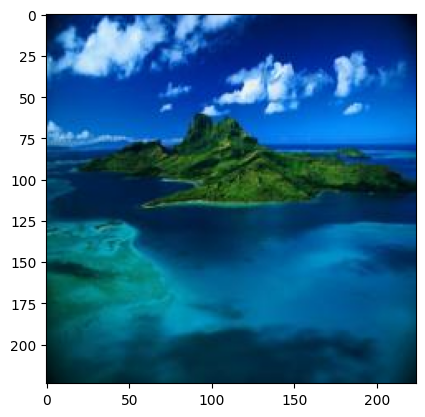

Iteration 0: Loss=0.00555984303355217


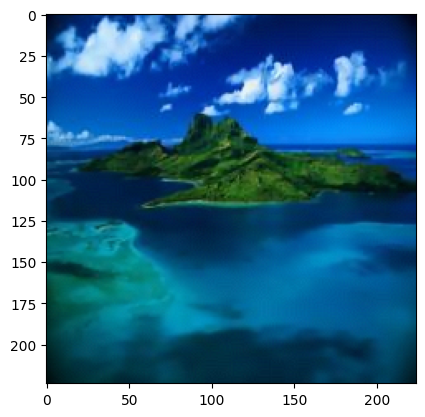

Iteration 100: Loss=0.001380610978230834


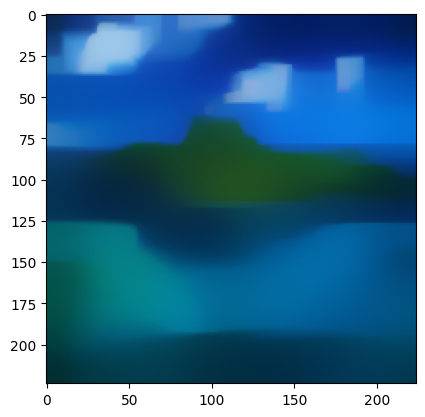

Iteration 200: Loss=0.0010307177435606718


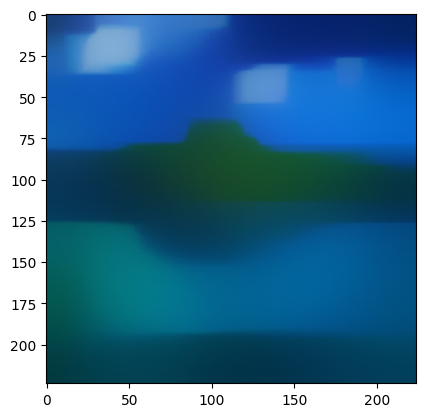

Iteration 300: Loss=0.0008416111231781542


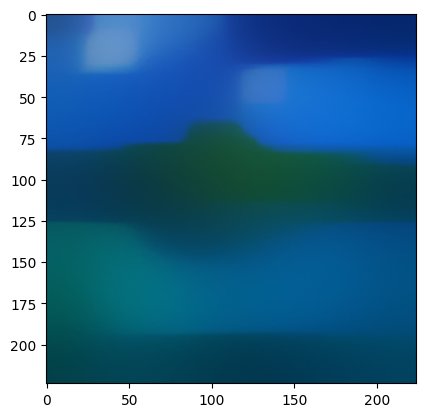

Iteration 400: Loss=0.0007251264760270715


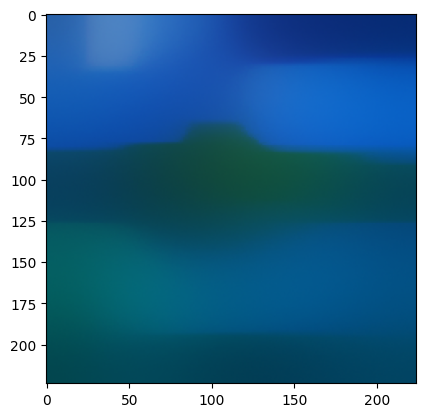

Iteration 500: Loss=0.0006476417183876038


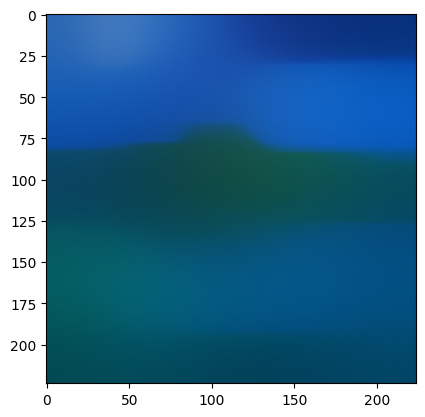

Iteration 600: Loss=0.000590916199143976


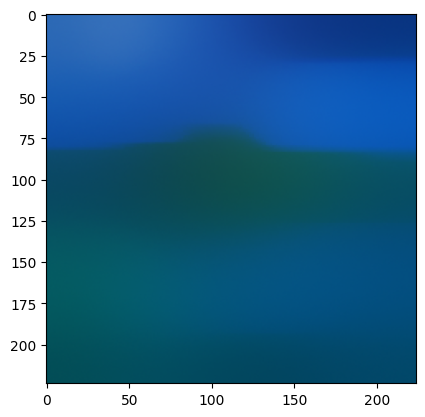

Iteration 700: Loss=0.0005497222300618887


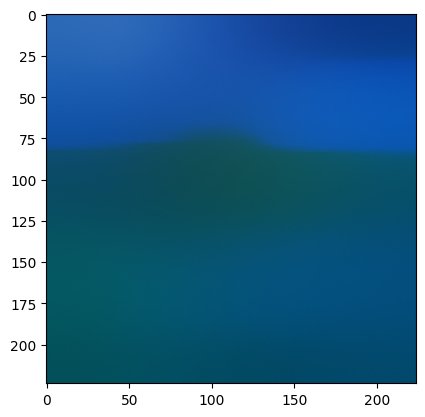

Iteration 800: Loss=0.0005174470716156065


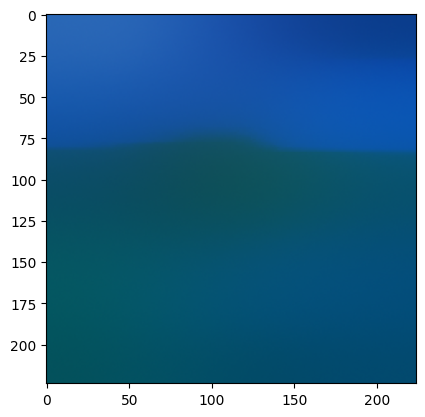

Iteration 900: Loss=0.0004959868965670466


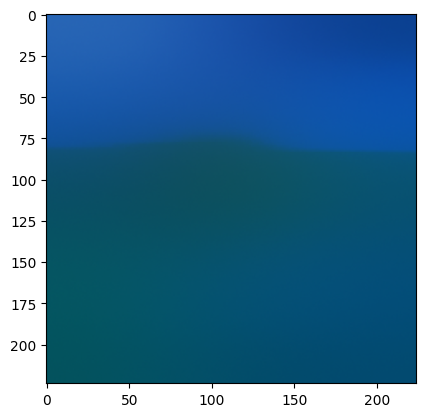

In [14]:
# Choose a random image without normalization
image = Image.open("{}/{}".format(image_path, "fl0b5.jpg"))

plt.imshow(image)
plt.show()

# Convert the image to a tensor without normalization
image_tensor = transforms.ToTensor()(image).unsqueeze(0)
img = image_tensor.clone().detach().requires_grad_(True)

# Set up the optimizer
optimizer = optim.Adam([img.requires_grad_()], lr=1e-2)

# Define the target output (near zero)
target = torch.tensor([[0]]).float()

# Run the optimization loop
tv_weight = 1e-6
for i in range(1000):
    optimizer.zero_grad()
    output = model(img)
    loss = criterion(output, target) + tv_weight * torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + tv_weight * torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    loss.backward()
    optimizer.step()
    
    # Clip the pixel values to stay within [0, 1] range
    img.data = torch.clamp(img.data, 0, 1)
    
    # Print the loss every 100 iterations
    if i % 100 == 0:
        print("Iteration {}: Loss={}".format(i, loss.item()))
        plt.imshow(img.squeeze().permute(1, 2, 0).detach().numpy())
        plt.show()


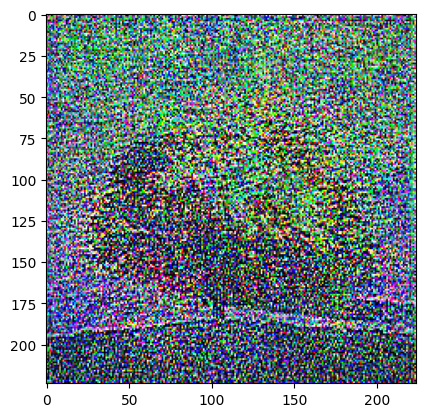

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img.squeeze().permute(1, 2, 0).detach().numpy())
plt.show()

### Predicting amount of upvotes

In [24]:
# Assuming you have the trained model saved as 'model.pth'
model_path = 'saved_model.pth'

# Load the trained model
model = Model()
model.load_state_dict(torch.load(model_path))
model.eval()

# Preprocess the input image
input_image = Image.open("{}/{}".format(image_path, "fl0b5.jpg"))
input_image = input_image.resize((224, 224))
input_tensor = transform(input_image).unsqueeze(0)

# Pass the image through the model
with torch.no_grad():
    output = model(input_tensor)

# Interpret the predicted output
predicted_upvotes = output.item()
print("Predicted upvotes:", predicted_upvotes)


Predicted upvotes: 0.05210113525390625


### Feature highlighter

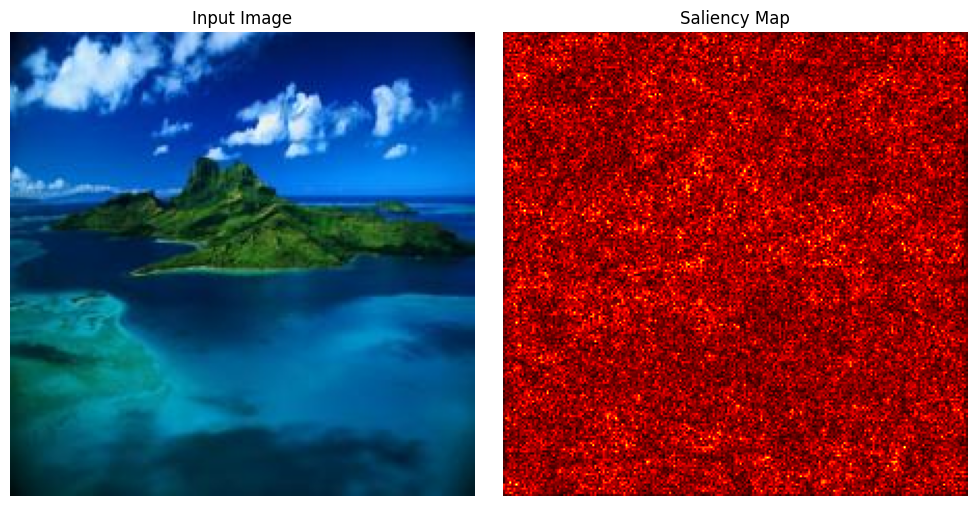

In [21]:
import numpy as np
import matplotlib.pyplot as plt


# Assuming you have the trained model saved as 'model.pth'
model_path = 'saved_model.pth'

# Load the trained model
model = Model()
model.load_state_dict(torch.load(model_path))
model.eval()

# Preprocess the input image
input_image = Image.open("{}/{}".format(image_path, "fl0b5.jpg"))
input_image = input_image.resize((224, 224))
input_tensor = transform(input_image).unsqueeze(0)

# Set the model to evaluation mode and disable gradients
model.eval()
input_tensor.requires_grad_()

# Forward pass to obtain the output
output = model(input_tensor)

# Calculate the gradients of the output with respect to the input
output.backward()

# Get the gradients from the input tensor
gradients = input_tensor.grad[0]

# Convert the gradients to grayscale
grayscale_gradients = np.abs(gradients.numpy()).mean(axis=0)

# Normalize the gradients
normalized_gradients = (grayscale_gradients - np.min(grayscale_gradients)) / (
    np.max(grayscale_gradients) - np.min(grayscale_gradients)
)

# Plot the original image and the saliency map
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image)
axes[0].axis('off')
axes[0].set_title('Input Image')
axes[1].imshow(normalized_gradients, cmap='hot')
axes[1].axis('off')
axes[1].set_title('Saliency Map')
plt.tight_layout()
plt.show()


Tanker vi kan køre på

Neural Style Transfer
To generate an image that carries over some of the features learned by the network, you can try a technique called "neural style transfer". Neural style transfer involves combining the style of one image with the content of another image using deep neural networks. This technique can be used to generate images that resemble a particular style, while still retaining some of the features of the original content.